# Final project
The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition.

This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - \Delta t f'(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k)\big)
$$
where a sum is implied over $j$ on both the left hand side and the right hand side. Let us remark that while writing this last version of the equation we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$.  

This results in a linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

and 

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

## Step 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ 

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one

## Step 3

Solve the problem for all combinations of

1. eps = [01, .001]

2. ndofs = [16, 32, 64, 128]

3. degree = [1, 2, 3]

3. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? 

## Step 4 (Optional)

Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a Nonlinear problem at every step. Use scipy and numpy methods to solve the non linear iteration.

In [9]:
%pylab inline
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *

Populating the interactive namespace from numpy and matplotlib


In [10]:
# Step 1.1 

def F(eta):
    # Fill in with the derivative of the double well potential function
    return 2.*eta*(eta-1)**2 + 2.*eta**2 * (eta-1)

In [11]:
# Step 1.2

def compute_basis_functions(support_points, degree):
    # Create the container
    basis = list([])
    size = support_points.size
    # Compute the basis
    for i in range(size):
        c = support_points*0
        c[i] = 1
        bi = PPoly.from_spline(splrep(support_points,c,k=degree))
        basis.append(bi)
    return basis

In [12]:
q = linspace(0,1, 11)
basis_ = compute_basis_functions(q, 1)

In [13]:
# Step 1.3

def compute_global_quadrature(basis, n_gauss_quadrature_points):
    '''
    Requires:
        basis
        n_gauss_quadrature_points: usually degree + 1
    Returns:
        Quadrature Points
        Quadrature Weights
        * All of them defined according the basis
    '''
    # Create a Gauss quadrature formula with n_gauss_quadrature_points, extract the intervals from basis (i.e., unique(basis.x)), and 
    # create len(x)-1 shifted and scaled Gauss quadrature formulas that can be used to integrate on each interval. Put all of these 
    # together, and return the result
    intervals = unique(basis[0].x)
    qp, w = numpy.polynomial.legendre.leggauss(n_gauss_quadrature_points)
    
    # Scale
    qp = (qp+1)/2
    w /= 2
    
    # On each of the interval
    h = diff(intervals)
    Q = array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    W = array([w*h[i] for i in range(len(h))]).reshape((-1,))
    return Q, W

In [14]:
# Step 1.4

def compute_system_matrices(basis, global_quadrature, global_weights):
    '''
    Parameters
        basis
        global_quadrature (produced in P1.2)
        global_weights (produced in P1.2)
    '''
    # Get the basis functions on the quadrature points
    len_basis = len(basis)
    Bq = array([basis[i](global_quadrature) for i in range(len_basis)]).T
    dbasis = list([])
    # Get the derivativ of the basis
    for i in basis:
        dbasis.append(i.derivative(1))
    dBq = array([dbasis[i](global_quadrature) for i in range(len_basis)]).T
    # Compute the matrices M_ij = (v_i, v_j) and K_ij = (v_i', v_j') and return them
    
    M = einsum('qi, q, qj', Bq, global_weights, Bq)
    K = einsum('qi, q, qj', dBq, global_weights, dBq)
    return M, K

In [15]:
# Step 2.1

def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    # put together all the above functions, loop over time, and produce the result matrix eta, containing the solution at all points
    
    # Get the container
    T = 1.
    eta = np.zeros((int(T/dt), ndofs))
    
    # Get the basis
    support_points = np.linspace(0,1,ndofs)
    basis = compute_basis_functions(support_points, degree)
    Q, W = compute_global_quadrature(basis,degree+1)
    M, K = compute_system_matrices(basis, Q, W)
    
    A = M + dt * (eps * eps) * K
    eta_i = eta_0_function(support_points)
    
    for i in range(int(T/dt)):
        b = M.dot(eta_i - dt * F(eta_i))
        eta_ii = np.linalg.solve(A,b)
        eta[i,:] = eta_ii
        eta_i = eta_ii
    
    return eta, basis

In [16]:
# Step 2.2 

def plot_solution(eta, basis, stride, resolution):
    # plot eta[::stride], on x = linspace(0,1,resolution)
    x = linspace(0,1,resolution)
    
    B = np.zeros((resolution,len(basis)))
              
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
    
    eta_strided = eta[::stride].dot(B.T)
    len_eta = len(eta_strided)
    for i in range(len_eta):
        label_i = i / (len_eta-1)
        _ = plt.plot(x,eta_strided[i,:], label = "T = " + str(label_i)) 
    
    # plot(...)

    

In [17]:
# Step 3.1

def eta_0_func(x):
    return (sin(2*pi*x) + 1)

In [18]:
# func, eps, dt, ndofs, degree
dt_l = [.25, .125, .0625, .03125, .015625]
ndofs_l = [16, 32, 64, 128]
STRIDE = 100

# eta, basis, stride, resolution

def plot_df_n_ndofs(deg, eps, solver):
    plt.figure(figsize = [20,20])
    for dt in dt_l:
    
        str_len = len(range(int(1/dt)))
        stride = min(STRIDE, str_len - 1)
    
        for ndofs in ndofs_l:
            eta, basis = solver(eta_0_func, eps, dt, ndofs, deg)
            plt.subplot(len(dt_l), len(ndofs_l),dt_l.index(dt) * len(ndofs_l) + ndofs_l.index(ndofs) + 1)
            plt.title("With ndofs = " + str(ndofs) + " dt = " + str(dt))
            plt.xlabel("t")
            plt.ylabel("nk")
            plot_solution(eta, basis, stride, 1024)
            plt.legend()
            plt.tight_layout()


'''
eps = [01, .001]

ndofs = [16, 32, 64, 128]

degree = [1, 2, 3]

dt = [.25, .125, .0625, .03125, .015625]
'''

'\neps = [01, .001]\n\nndofs = [16, 32, 64, 128]\n\ndegree = [1, 2, 3]\n\ndt = [.25, .125, .0625, .03125, .015625]\n'

----------------------------------------------------------------
Deg:  1  Eps:  0.01
----------------------------------------------------------------


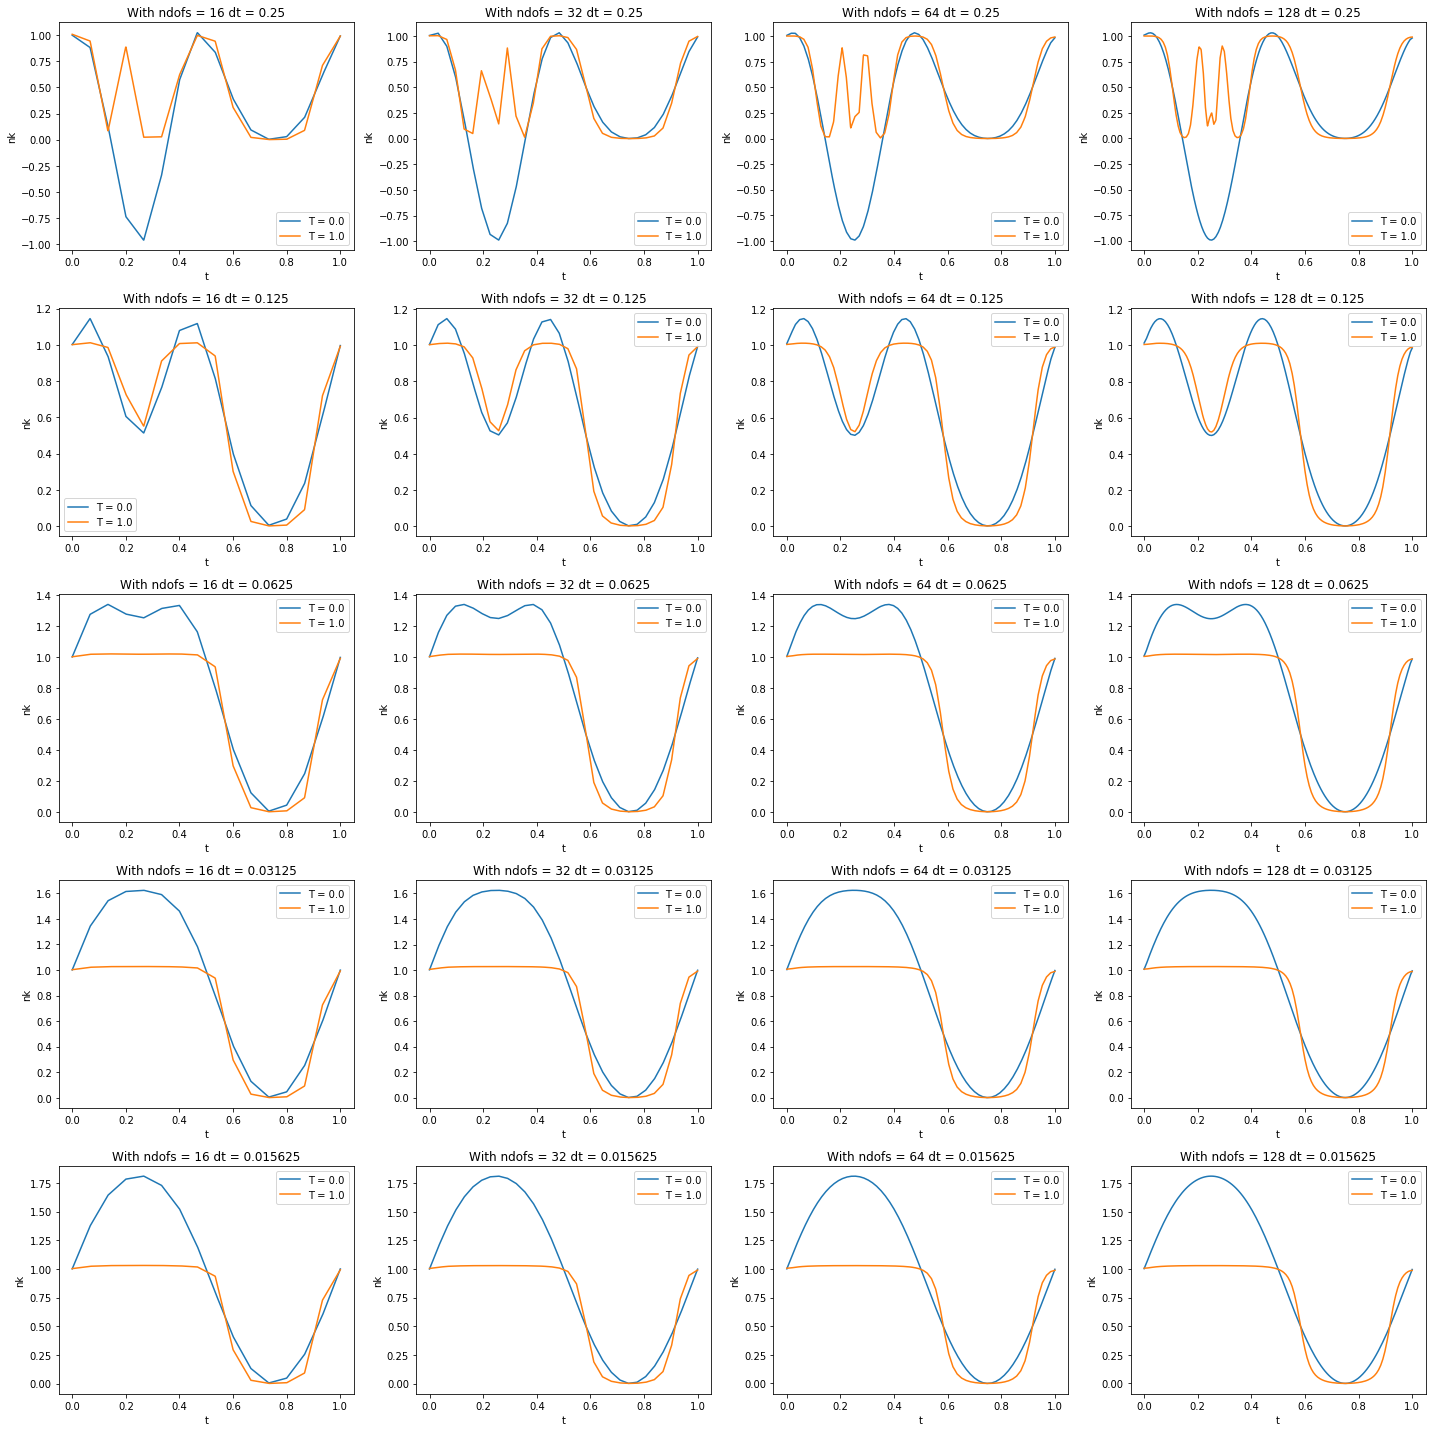

In [19]:
deg = 1
eps = 0.01
print("----------------------------------------------------------------")
print("Deg: ", deg, " Eps: ", eps)
print("----------------------------------------------------------------")
plot_df_n_ndofs(deg, eps, solve_allen_cahan) 

----------------------------------------------------------------
Deg:  2  Eps:  0.01
----------------------------------------------------------------


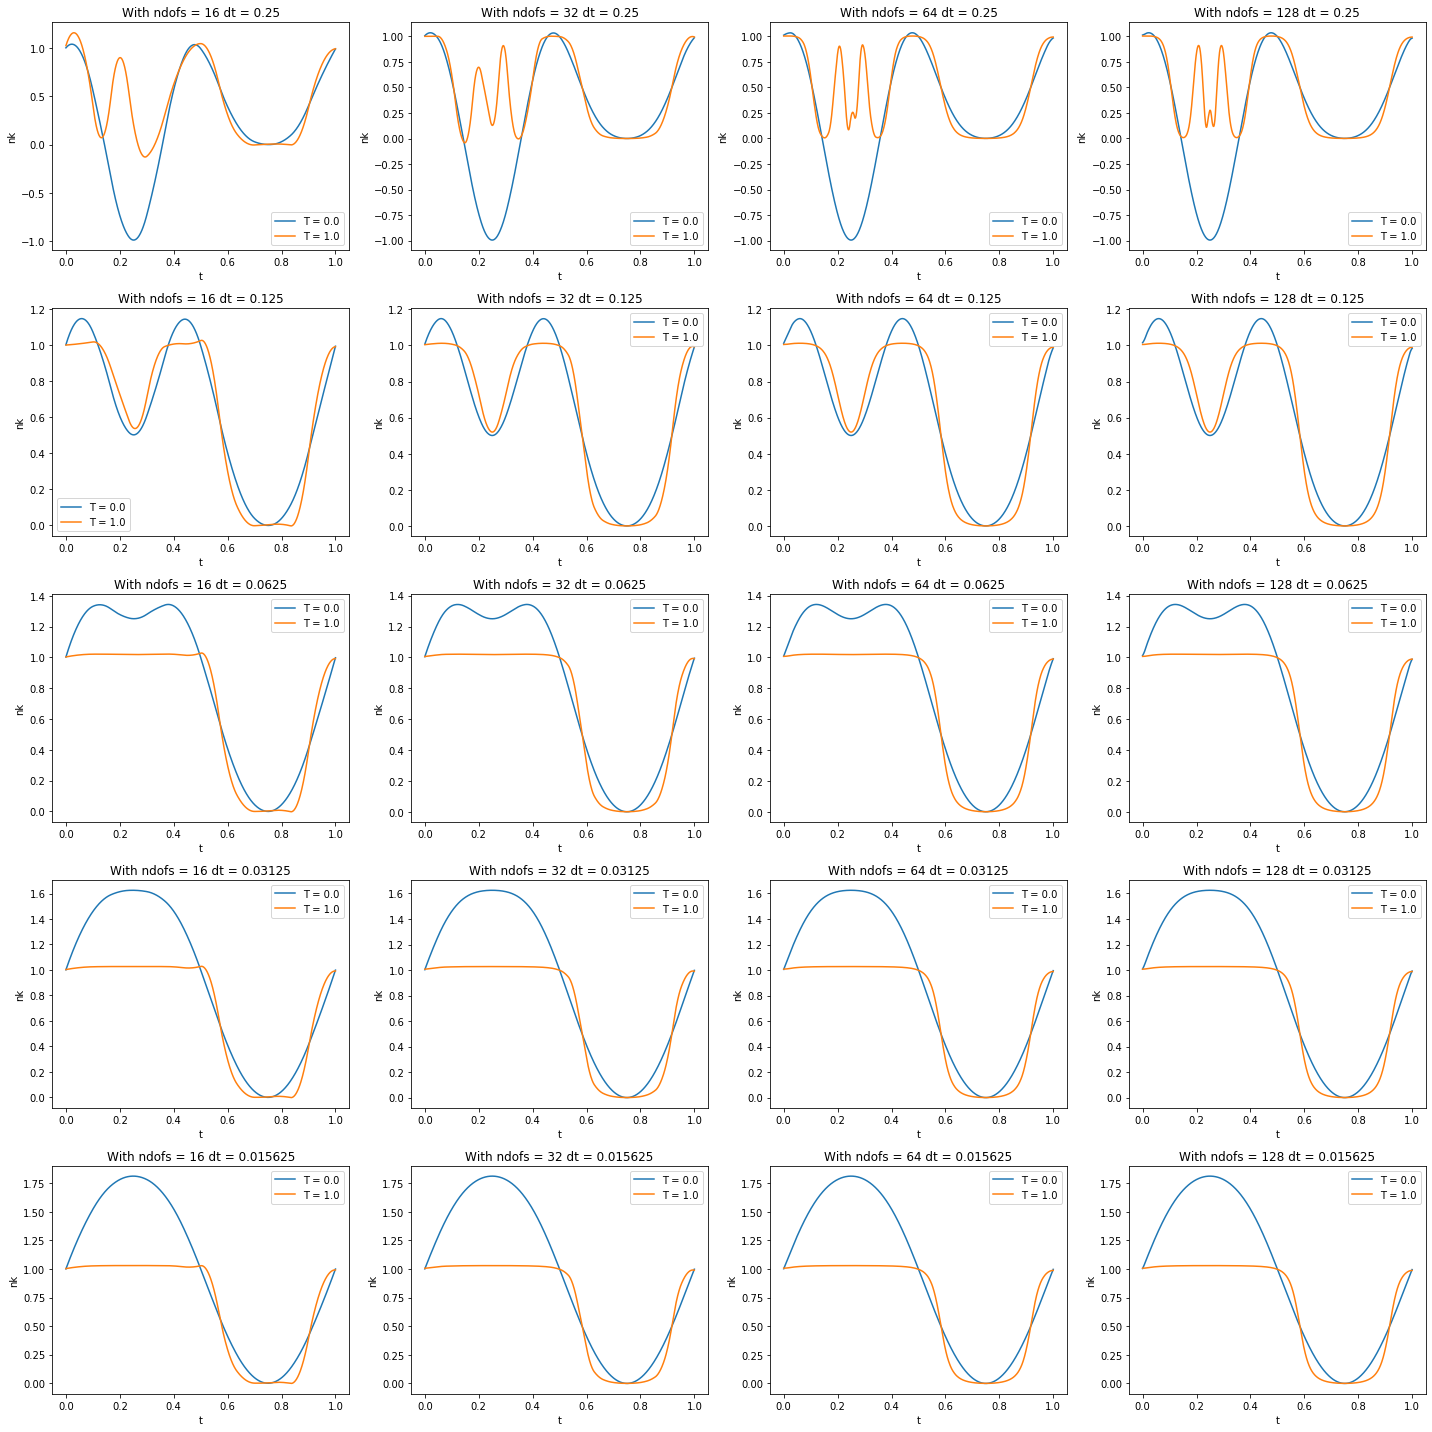

In [20]:
deg = 2
eps = 0.01
print("----------------------------------------------------------------")
print("Deg: ", deg, " Eps: ", eps)
print("----------------------------------------------------------------")
plot_df_n_ndofs(deg, eps, solve_allen_cahan) 

----------------------------------------------------------------
Deg:  3  Eps:  0.01
----------------------------------------------------------------


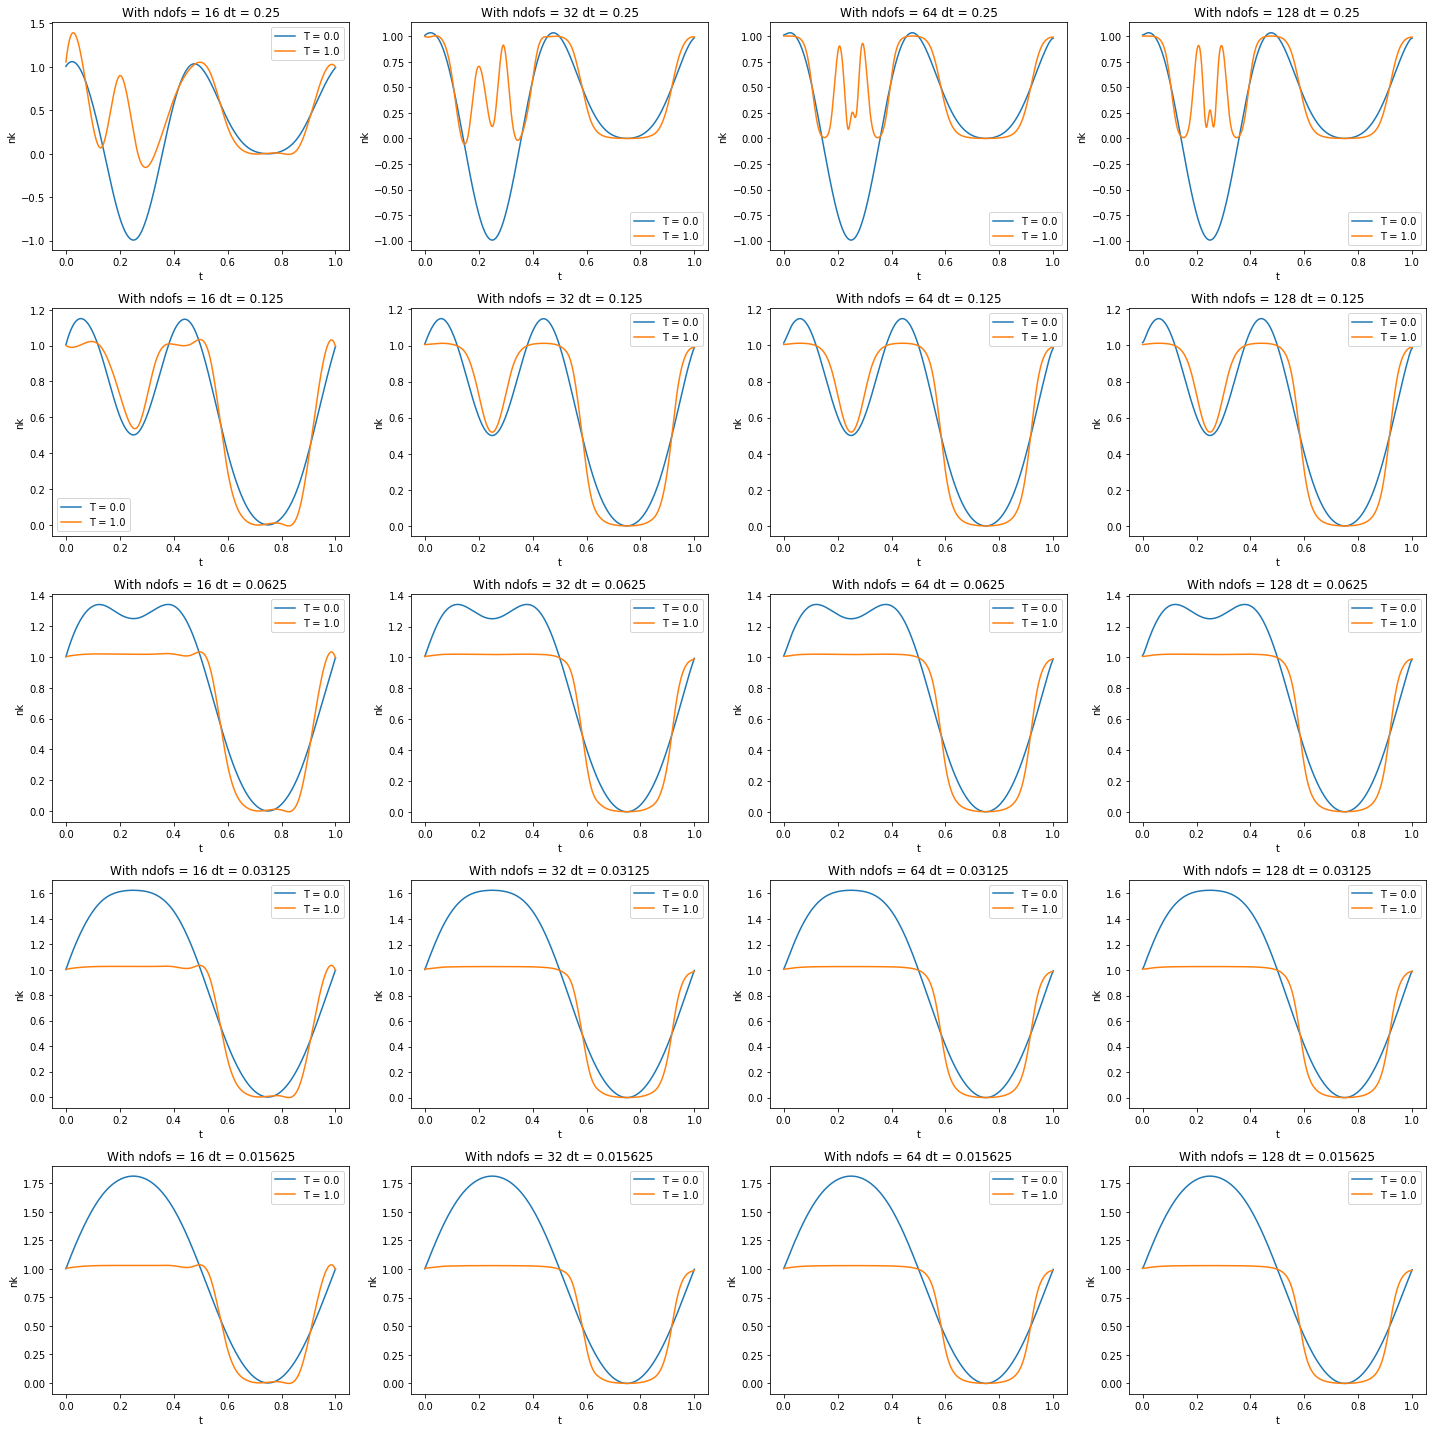

In [21]:
deg = 3
eps = 0.01
print("----------------------------------------------------------------")
print("Deg: ", deg, " Eps: ", eps)
print("----------------------------------------------------------------")
plot_df_n_ndofs(deg, eps, solve_allen_cahan) 

----------------------------------------------------------------
Deg:  1  Eps:  0.001
----------------------------------------------------------------


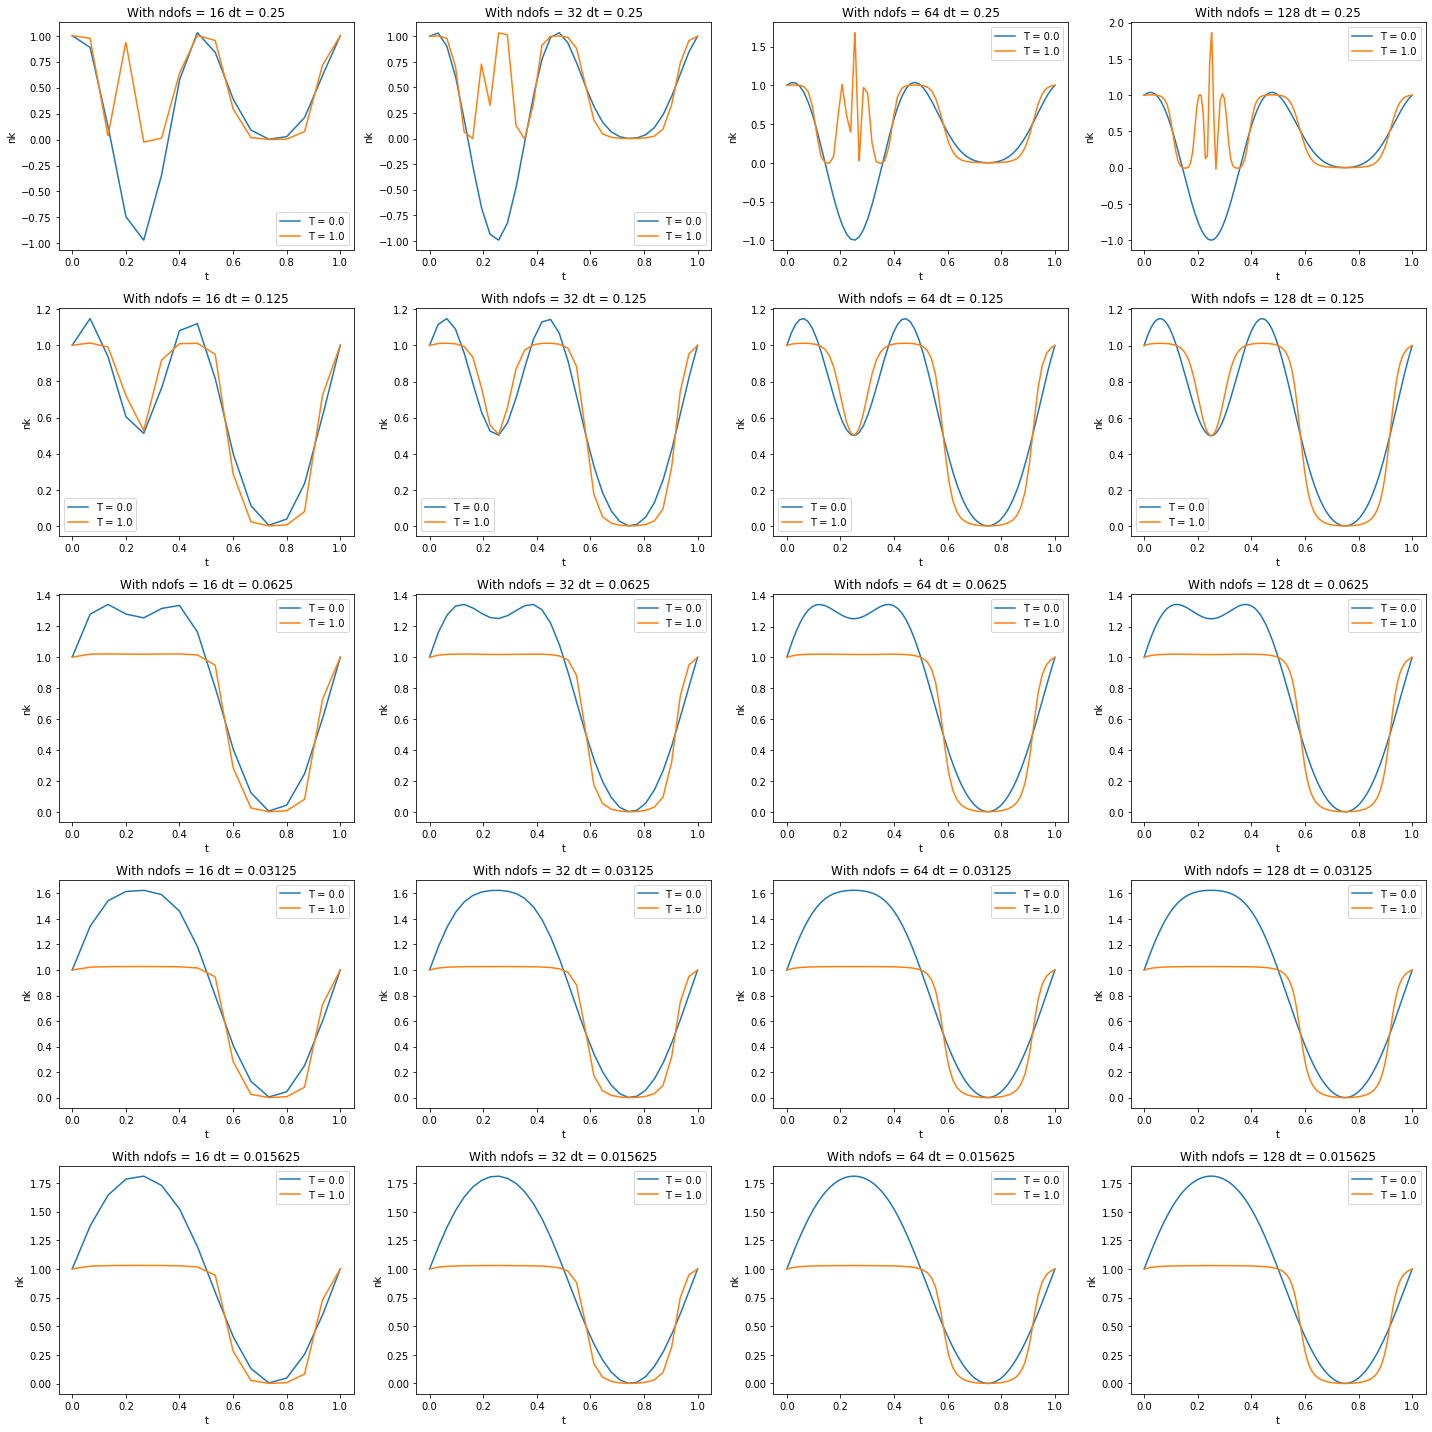

In [22]:
deg = 1
eps = 0.001
print("----------------------------------------------------------------")
print("Deg: ", deg, " Eps: ", eps)
print("----------------------------------------------------------------")
plot_df_n_ndofs(deg, eps, solve_allen_cahan)

----------------------------------------------------------------
Deg:  2  Eps:  0.001
----------------------------------------------------------------


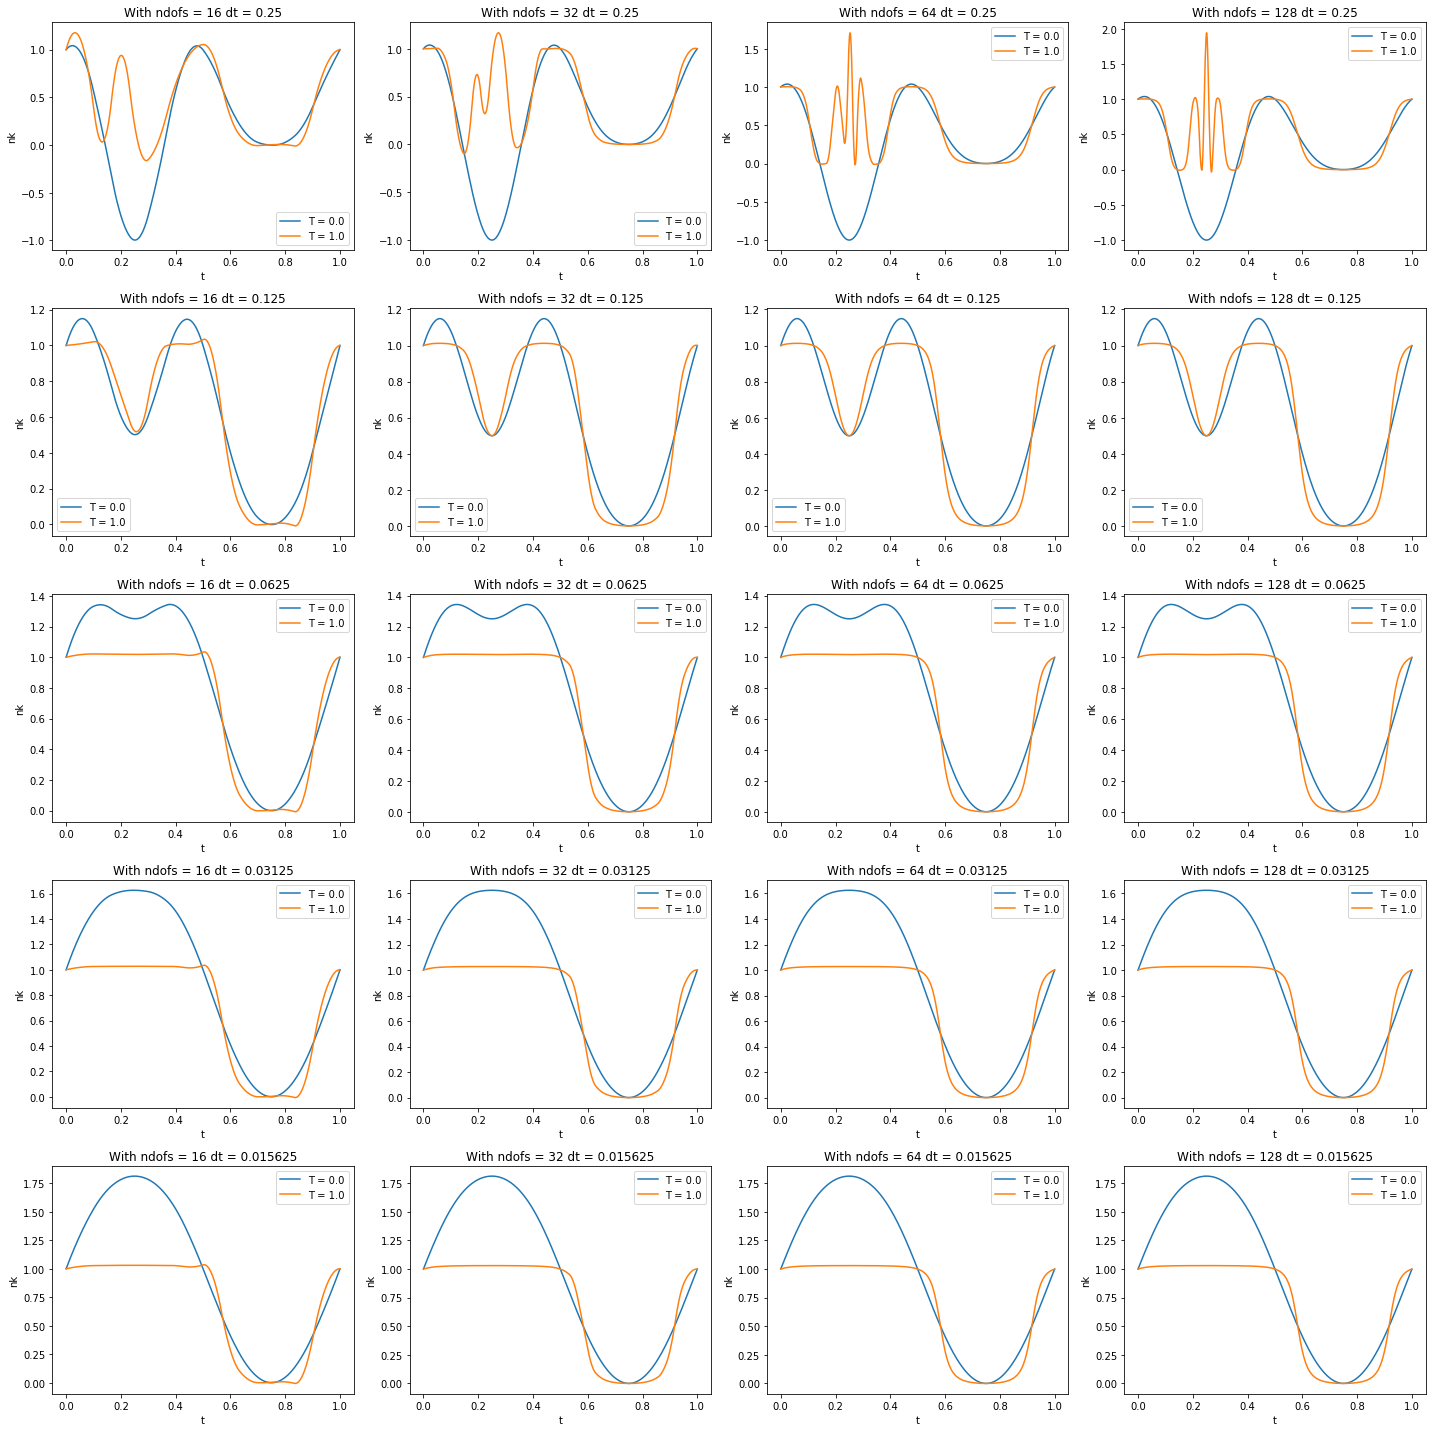

In [23]:
deg = 2
eps = 0.001
print("----------------------------------------------------------------")
print("Deg: ", deg, " Eps: ", eps)
print("----------------------------------------------------------------")
plot_df_n_ndofs(deg, eps, solve_allen_cahan) 

----------------------------------------------------------------
Deg:  3  Eps:  0.001
----------------------------------------------------------------


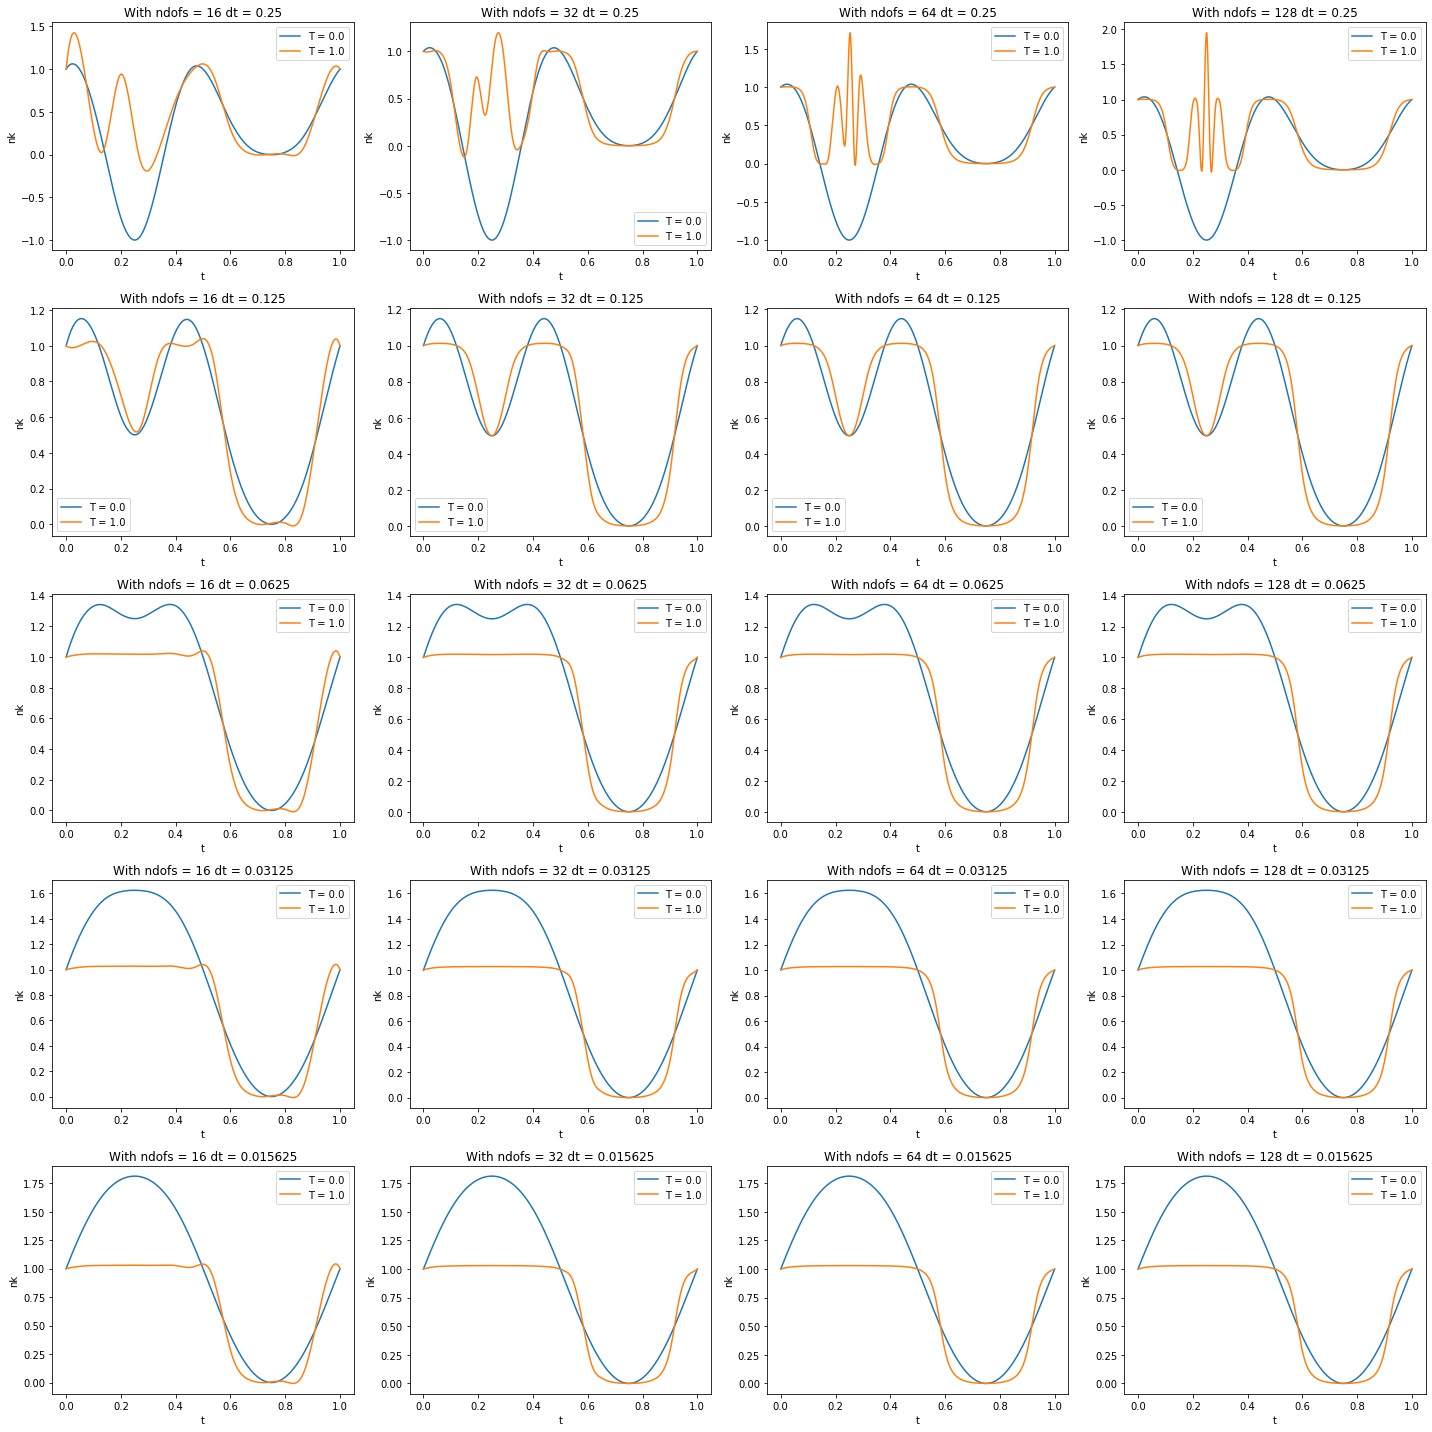

In [24]:
deg = 3
eps = 0.001
print("----------------------------------------------------------------")
print("Deg: ", deg, " Eps: ", eps)
print("----------------------------------------------------------------")
plot_df_n_ndofs(deg, eps, solve_allen_cahan) 

## Observations

According to the plots, increasing the number of degrees of freedom resulted in less oscillations, especially when the time step increases. Howeverm the number of oscillations decreases by decreasing the number of time steps (dt). 

The time step influenced the shape of the wave in T=0 and T=1.0, where the initial wave (T=0) in lower time steps were similar to a sine function and the last wave was similar to a series of step functions (initially in 1, then went to 0 and raised again to 1). This kind of waves kind be found in electronics, especially in digital systems, where the parasitic elements play an important role in the shape of the step functions.

The épsilon also plays a role in the number of spikes seen when the dt is great and the ndofs is large. 

Finally the degree affects the oscillations, when the ndofs is low and the dt is small, it is possible to observe that the function is sharpener than when having a higher degree.

In [27]:
# Step 4 - Optional

def solve_allen_cahan_backward_euler(eta_0_function, eps, dt, ndofs, degree):
    # put together all the above functions, loop over time, and produce the result matrix eta, containing the solution at all points
    
    # Get the container
    T = 1.
    eta = np.zeros((int(T/dt), ndofs))
    
    # Get the basis
    support_points = np.linspace(0,1,ndofs)
    basis = compute_basis_functions(support_points, degree)
    Q, W = compute_global_quadrature(basis,degree+1)
    M, K = compute_system_matrices(basis, Q, W)
    
    def implicit_f(x):
        Ax = M.dot(x) + dt * (eps * eps) * K.dot(x)
        Bx = M.dot(eta_i) - dt * M.dot(F(x)) 
        return Ax - Bx
    
    eta_i = eta_0_function(support_points)
    
    for i in range(int(T/dt)):
        implicit_f = lambda x: M.dot(x) + dt * (eps * eps) * K.dot(x) - M.dot(eta_i) + dt * M.dot(F(x)) 
        eta_ii = scipy.optimize.newton(implicit_f, eta_i, maxiter = 200)
        eta[i,:] = eta_ii
        eta_i = eta_ii
    
    return eta, basis

----------------------------------------------------------------
Deg:  1  Eps:  0.01
----------------------------------------------------------------


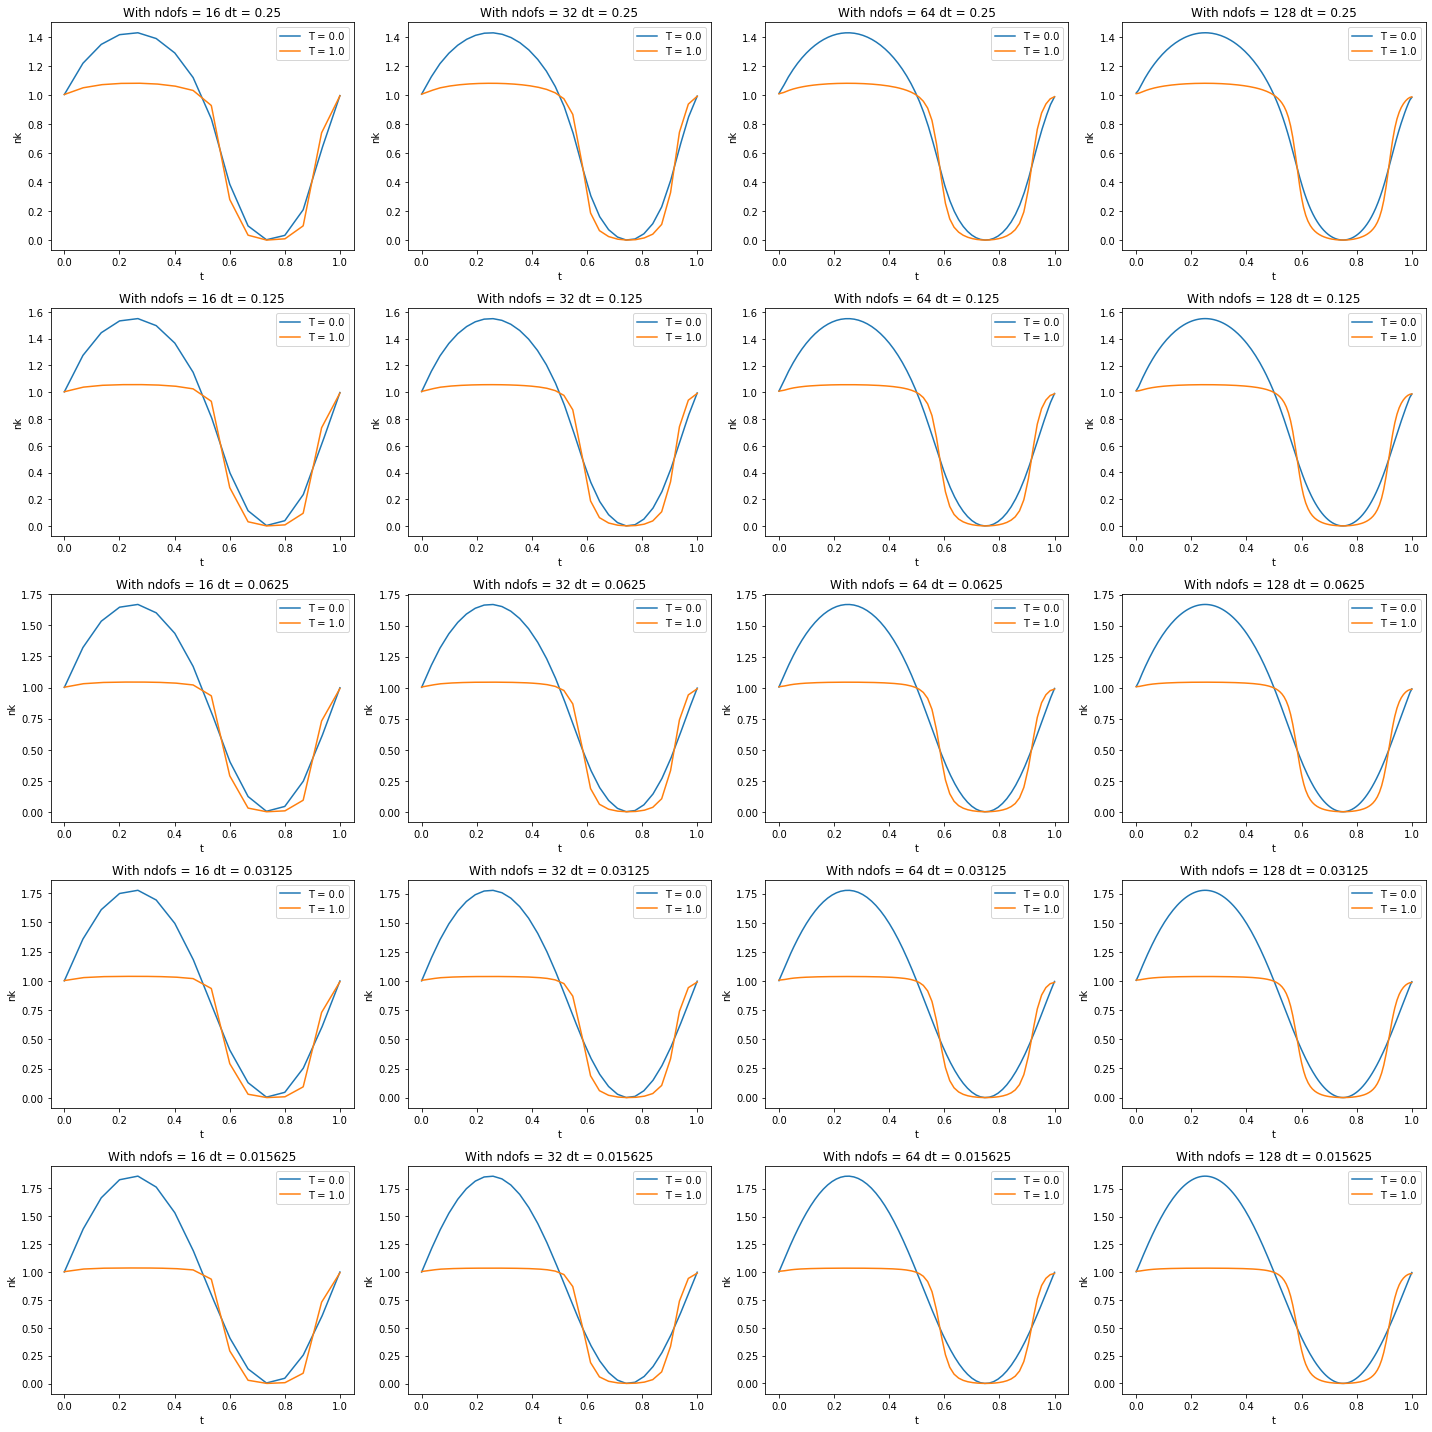

In [28]:
deg = 1
eps = 0.01
print("----------------------------------------------------------------")
print("Deg: ", deg, " Eps: ", eps)
print("----------------------------------------------------------------")
plot_df_n_ndofs(deg, eps, solve_allen_cahan_backward_euler) 

----------------------------------------------------------------
Deg:  3  Eps:  0.01
----------------------------------------------------------------


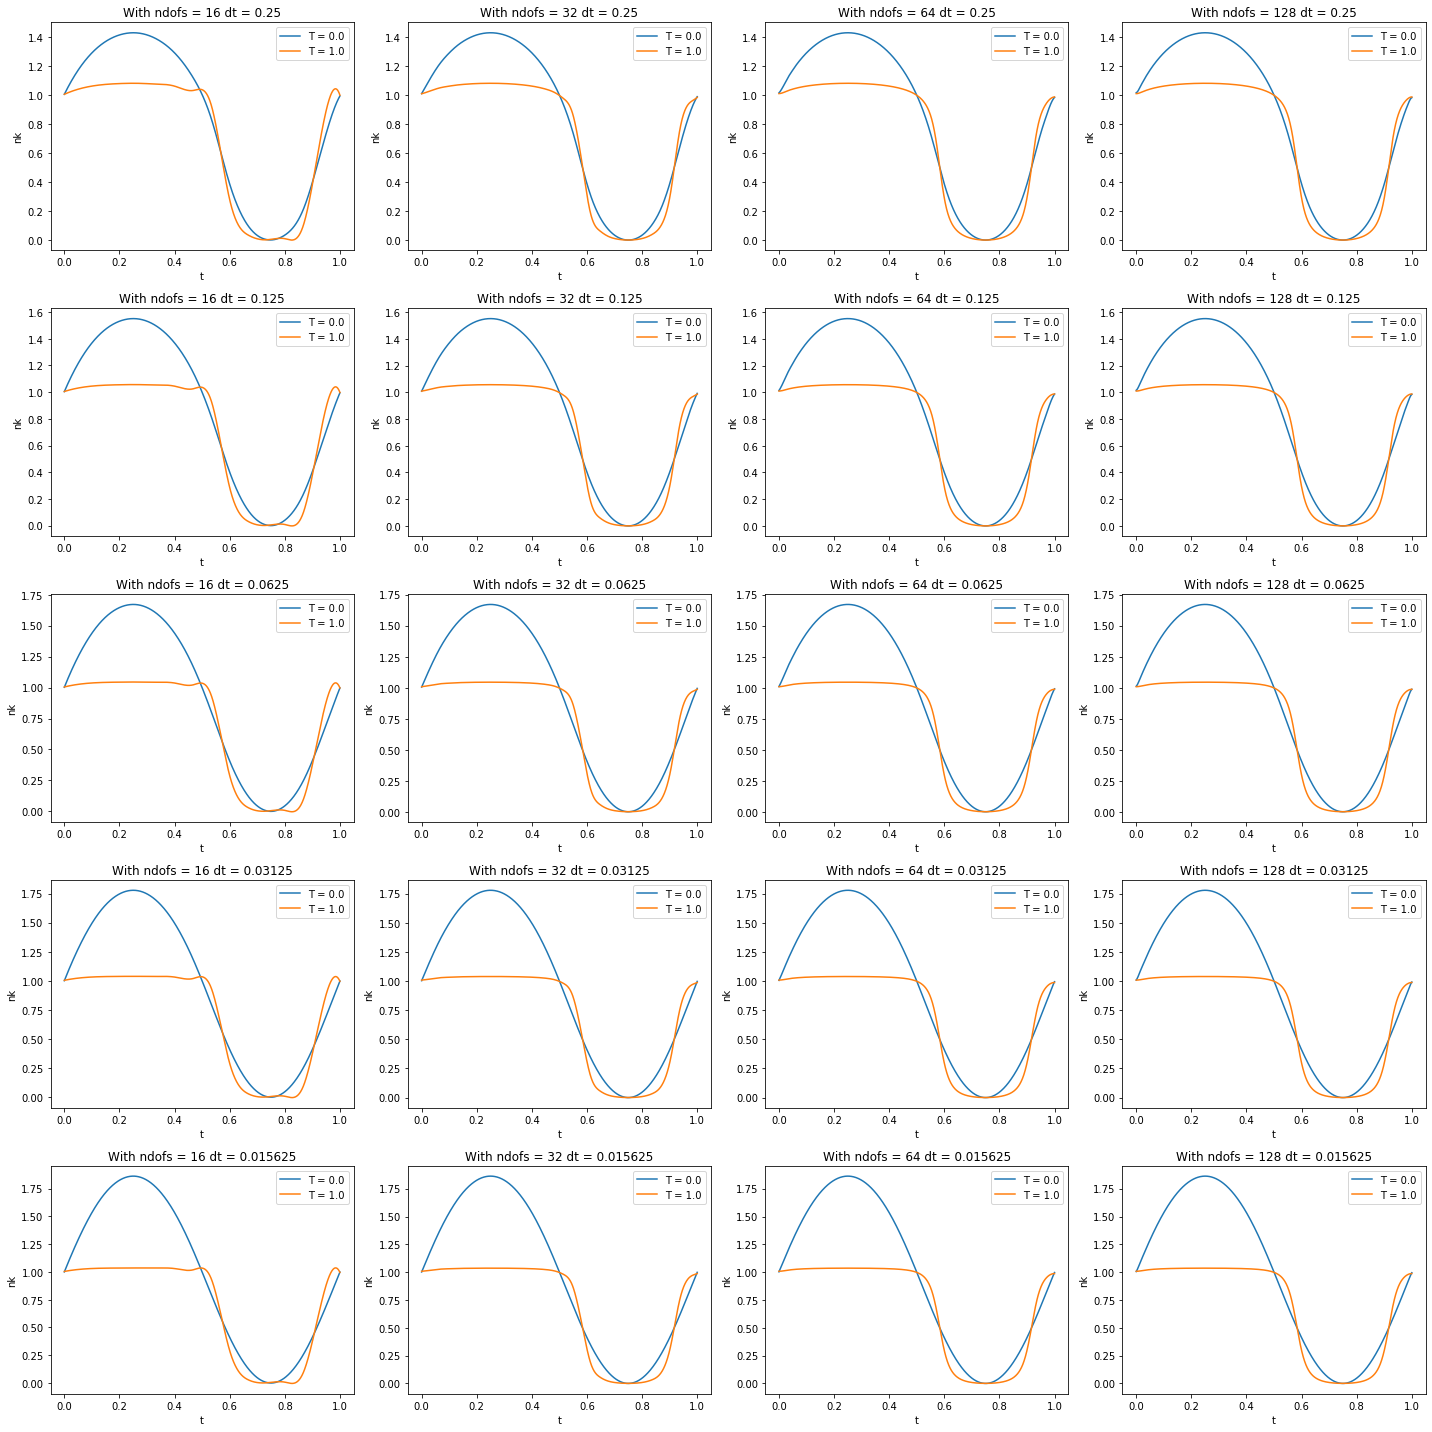

In [31]:
deg = 3
eps = 0.01
print("----------------------------------------------------------------")
print("Deg: ", deg, " Eps: ", eps)
print("----------------------------------------------------------------")
plot_df_n_ndofs(deg, eps, solve_allen_cahan_backward_euler) 

## Observations

With the backward euler and using scipy optimize, it is possible to get the solution with less oscillations and keeping low the ndofs and high the time step.